In [1]:
import nltk
import torch

# nltk.download('punkt_tab')
import sys
import os
import pandas as pd

# pip install keybert
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

# pip install wordcloud
from wordcloud import WordCloud

d:\miniconda\envs\networks\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load transformers on the GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = SentenceTransformer("all-MiniLM-L6-v2", device=device)  # KeyBERT default model
# keyword_model = KeyBERT('distilbert-base-nli-mean-tokens')
# similarity_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
keyword_model = KeyBERT(model)
similarity_model = model

Using device: cuda


d:\miniconda\envs\networks\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Nico\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [3]:
# loading and preprocessing articles
def get_articles_by_directory(directory):
    articles = []
    article_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".txt"):
                try:
                    with open(os.path.join(root, file), "r", errors="ignore") as f:
                        articles.append(f.read())
                        article_paths.append(os.path.join(root, file))
                except Exception as e:
                    print(f"Error reading file: {os.path.join(root, file)}\n{e}")
                    continue
    print(f"Loaded {len(articles)} articles in {directory}.")
    return articles, article_paths


def tokenize(articles):
    tokenized_articles = []
    for article in articles:
        try:
            tokenized_articles.append(nltk.sent_tokenize(article))
        except Exception as e:
            print(f"Tokenization error:\n{e}")
            continue
    # print(f"Tokenized {len(articles)} articles.")
    return tokenized_articles


def get_type(path):
    if "Presse" in path:
        return "Presse"
    elif "NGO" in path:
        return "NGO"
    elif "IGO" in path:
        return "IGO"
    assert False, f"Could not determine type of article: {path}"


def get_org(path):
    # path = path.split("/")[-1]  # remove everything before the last slash
    path = path.split("\\")[-1]  # remove everything before the last slash
    path = path.split("-")[0]  # remove everything after the first hyphen
    return path


def generate_article_df(directory):
    articles, article_paths = get_articles_by_directory(directory)
    articles = tokenize(articles)
    articles = [" ".join(article) for article in articles]
    types = [get_type(path) for path in article_paths]
    orgs = [get_org(path) for path in article_paths]
    titles = [path.split("/")[-1] for path in article_paths]

    return pd.DataFrame({"title": titles, "article": articles, "type": types, "org": orgs})


def filter_df(df, type=None, org=None):
    if type is not None:
        df = df[df["type"] == type]
    if org is not None:
        df = df[df["org"] == org]
    print(f"Filtered to {len(df)} with type={type} and org={org}.")
    return df

In [9]:
# keyword extraction
def get_keywords_from_df(df, verbose=False, range=(1, 2), top_n=20, diversity=0.7):
    all_keywords = []
    i = 0
    for _, row in df.iterrows():
        i += 1
        sys.stdout.write("\rExtracting keywords... {}/{}".format(i, len(df)))
        sys.stdout.flush()
        keywords = keyword_model.extract_keywords(
            row["article"],
            keyphrase_ngram_range=range,
            stop_words="english",
            top_n=top_n,
            diversity=diversity,
            use_mmr=True,
        )
        all_keywords.extend(keywords)

        if verbose:
            print(row["title"])
            for keyword, score in keywords:
                print(f"\t{keyword} ({round(score, 2)})")
    sys.stdout.write("\n")

    keywords_df = pd.DataFrame(all_keywords, columns=["Keyword", "Score"])
    keyword_scores = keywords_df.groupby("Keyword").agg({"Score": "sum"}).sort_values(by="Score", ascending=False)
    if verbose:
        print(keyword_scores.head(30))

    return keyword_scores


def group_similar_keywords(keywords, scores, cosine_similarities, threshold=0.85):
    grouped_keywords = []
    used_indices = set()

    for i, keyword in enumerate(keywords):
        sys.stdout.write("\rGrouping similar keywords... {}/{}".format(i + 1, len(keywords)))
        sys.stdout.flush()
        if i in used_indices:
            continue
        grouped_keyword = {"keyword": keyword, "similar_keywords": [keyword], "scores": [scores[i]]}
        for j, score in enumerate(cosine_similarities[i]):
            if i != j and score > threshold:
                grouped_keyword["similar_keywords"].append(keywords[j])
                grouped_keyword["scores"].append(scores[j])
                used_indices.add(j)
        grouped_keyword["score_sum"] = round(sum(grouped_keyword["scores"]), 2)
        grouped_keywords.append(grouped_keyword)
    sys.stdout.write("\n")
    return grouped_keywords


def filter_keywords(keywords, min_score=0.5, max_keywords=100):
    filtered_keywords = [keyword for keyword in keywords if keyword["score_sum"] >= min_score]
    filtered_keywords = sorted(filtered_keywords, key=lambda x: x["score_sum"], reverse=True)[:max_keywords]
    print(f"Filtered keywords from {len(keywords)} to {len(filtered_keywords)}")
    return filtered_keywords

In [5]:
# visualization
def create_wordcloud(keyword_scores, title="", save=""):
    keyword_scores = {keyword["keyword"]: keyword["score_sum"] for keyword in keyword_scores}
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(keyword_scores)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    if title:
        plt.title(title)
    plt.axis("off")
    if save:
        plt.savefig(save)
    plt.show()


def create_bar_chart(keyword_scores, title="", save=""):
    keyword_scores = {keyword["keyword"]: keyword["score_sum"] for keyword in keyword_scores}
    keywords, scores = zip(*keyword_scores.items())
    plt.figure(figsize=(10, 5))
    plt.barh(keywords, scores, color="skyblue")
    if title:
        plt.title(title)
    plt.xlabel("Relevance Score")
    plt.ylabel("Keywords")
    plt.gca().invert_yaxis()  # To display the highest score at the top
    if save:
        plt.savefig(save)
    plt.show()


def save_keywords_to_file(keywords, path):
    with open(path, "w") as f:
        for keyword in keywords:
            f.write(f"{keyword['keyword']};{keyword['score_sum']}\n")

In [10]:
def keyword_analysis(df, title, path_prefix="COP/plots/keyword_analysis"):
    print(f"Analyzing keywords for {title}...")
    keywords = get_keywords_from_df(df)
    keywords.head(30)
    embeddings = similarity_model.encode(keywords.index, convert_to_tensor=True, device=device)
    cosine_similarities_matrix = util.pytorch_cos_sim(embeddings, embeddings)
    grouped_keywords = group_similar_keywords(
        list(keywords.index), list(keywords["Score"]), cosine_similarities_matrix, threshold=0.8
    )
    filtered_keywords = filter_keywords(grouped_keywords, min_score=1.0, max_keywords=100)
    save_keywords_to_file(filtered_keywords, path=path_prefix + f"/scores/{title}.csv")
    create_wordcloud(filtered_keywords, title=title, save=path_prefix + f"/wordcloud/{title}.png")
    filtered_keywords = filter_keywords(grouped_keywords, min_score=1.0, max_keywords=20)
    create_bar_chart(filtered_keywords, title=title, save=path_prefix + f"/bar_chart/{title}.png")

In [7]:
articles_df = generate_article_df("COP/articles/by_org/")
presse_df = filter_df(articles_df, type="Presse")
presse_ft_df = filter_df(presse_df, type="Presse", org="FT")
presse_nyt_df = filter_df(presse_df, type="Presse", org="NYT")
presse_guardian_df = filter_df(presse_df, type="Presse", org="Guardian")
presse_usatoday_df = filter_df(presse_df, type="Presse", org="USAToday")
presse_telegraph_df = filter_df(presse_df, type="Presse", org="Telegraph")
igo_df = filter_df(articles_df, type="IGO")
ngo_df = filter_df(articles_df, type="NGO")

dfs = {
    "IGO": igo_df,
    "NGO": ngo_df,
    "Presse FT": presse_ft_df,
    "Presse NYT": presse_nyt_df,
    "Presse Guardian": presse_guardian_df,
    "Presse USAToday": presse_usatoday_df,
    "Presse Telegraph": presse_telegraph_df,
    "Presse": presse_df,
}

articles_df.head()

Loaded 1561 articles in COP/articles/by_org/.
Filtered to 1433 with type=Presse and org=None.
Filtered to 351 with type=Presse and org=FT.
Filtered to 377 with type=Presse and org=NYT.
Filtered to 269 with type=Presse and org=Guardian.
Filtered to 166 with type=Presse and org=USAToday.
Filtered to 270 with type=Presse and org=Telegraph.
Filtered to 47 with type=IGO and org=None.
Filtered to 81 with type=NGO and org=None.


,title,article,type,org
0,IGO\IGO_COP15\IPCC-2007-1.txt,A report of Working Group I of the Intergovern...,IGO,IPCC
1,IGO\IGO_COP15\IPCC-2007-2.txt,Climate Change 2007: Synthesis Report Summary ...,IGO,IPCC
2,IGO\IGO_COP15\IPCC-2007-3.txt,Contribution of Working Group II to the Fourth...,IGO,IPCC
3,IGO\IGO_COP15\IPCC-2007-4.txt,Contribution of Working Group III to the Fourt...,IGO,IPCC
4,IGO\IGO_COP15\REDD-2010-3.txt,Investing in REDD-plus Consensus Recommendati...,IGO,REDD


Analyzing keywords for IGO...
Extracting keywords... 47/47
Grouping similar keywords... 901/901
Filtered keywords from 870 to 9


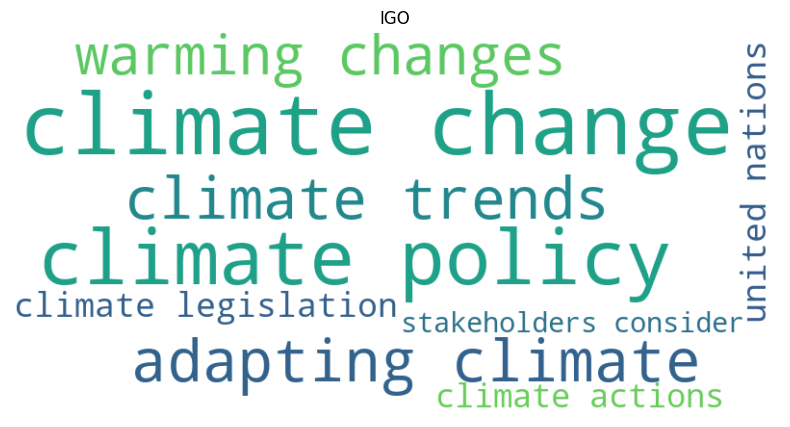

Filtered keywords from 870 to 9


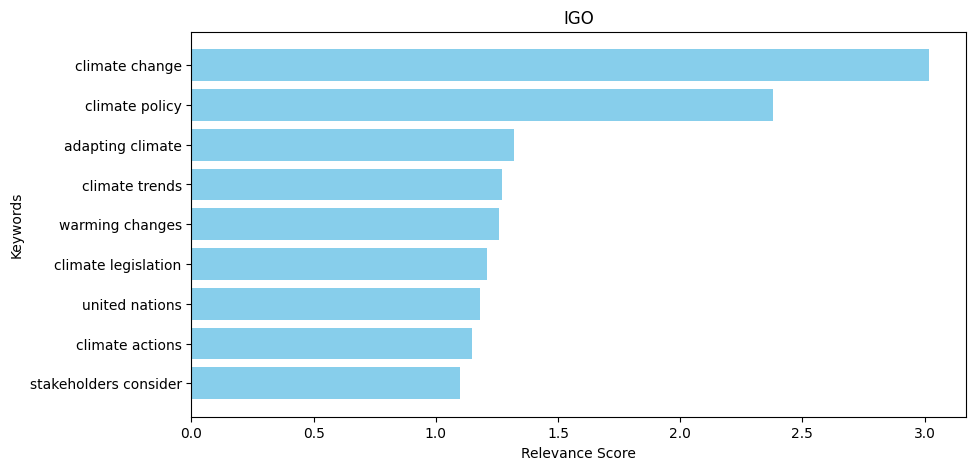

Analyzing keywords for NGO...
Extracting keywords... 81/81
Grouping similar keywords... 1574/1574
Filtered keywords from 1541 to 8


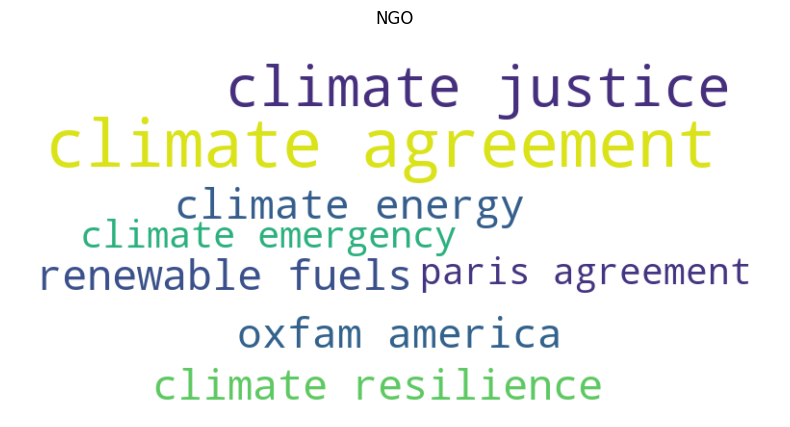

Filtered keywords from 1541 to 8


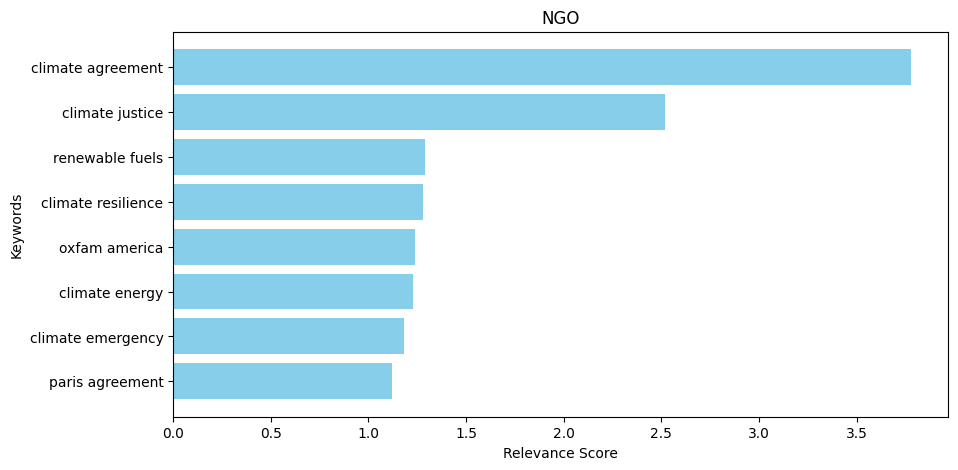

Analyzing keywords for Presse FT...
Extracting keywords... 351/351
Grouping similar keywords... 6464/6464
Filtered keywords from 5859 to 100


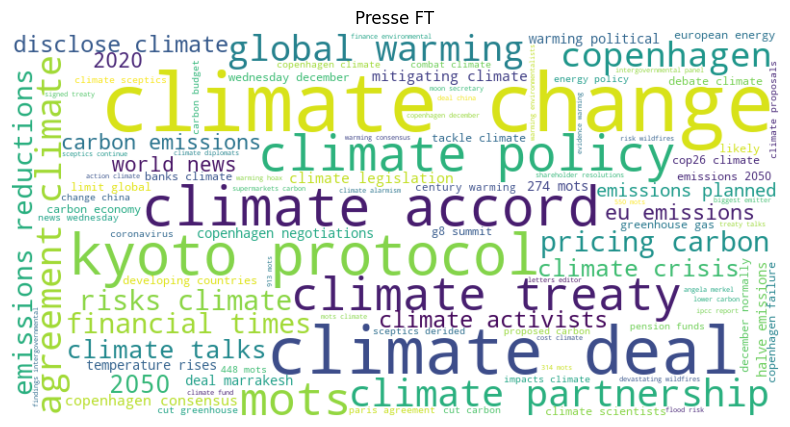

Filtered keywords from 5859 to 20


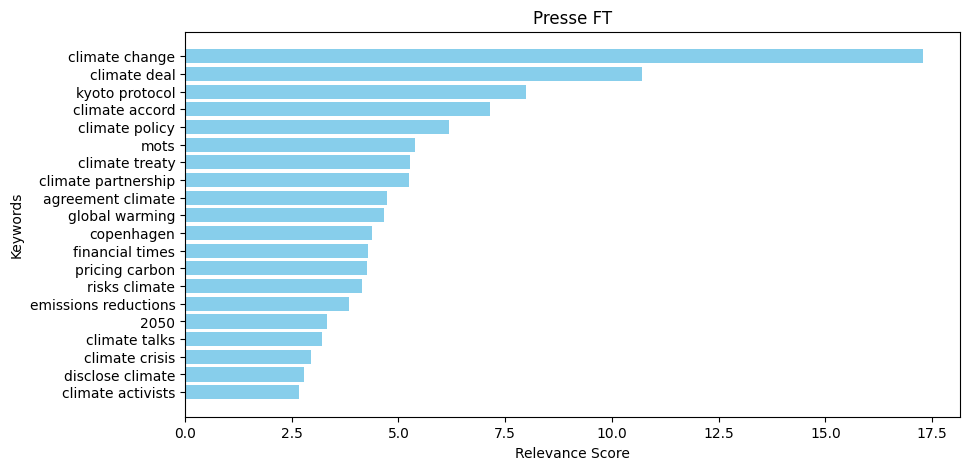

Analyzing keywords for Presse NYT...
Extracting keywords... 377/377
Grouping similar keywords... 7075/7075
Filtered keywords from 6570 to 90


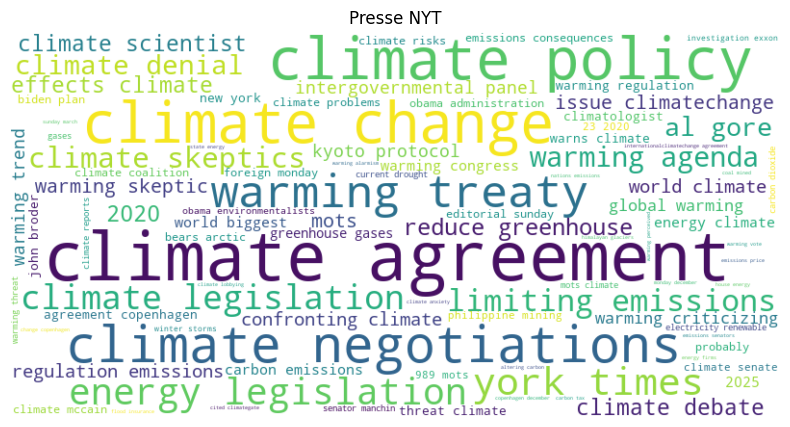

Filtered keywords from 6570 to 20


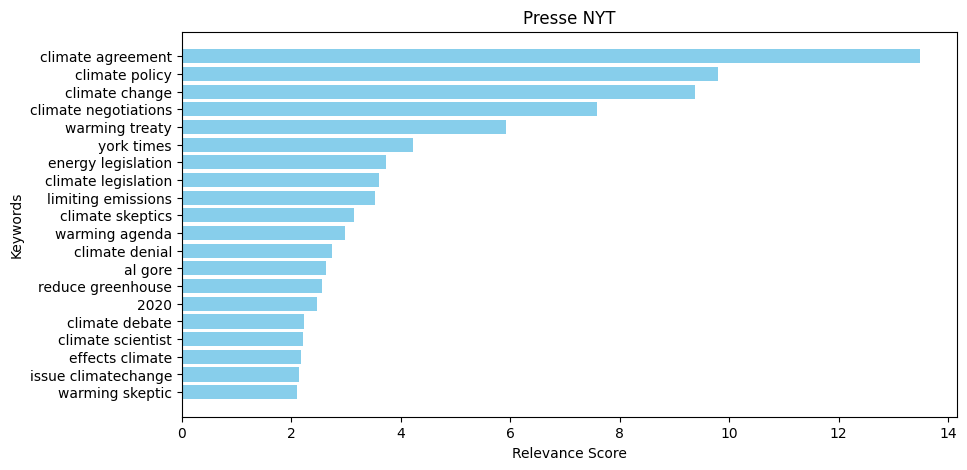

Analyzing keywords for Presse Guardian...
Extracting keywords... 269/269
Grouping similar keywords... 5068/5068
Filtered keywords from 4784 to 60


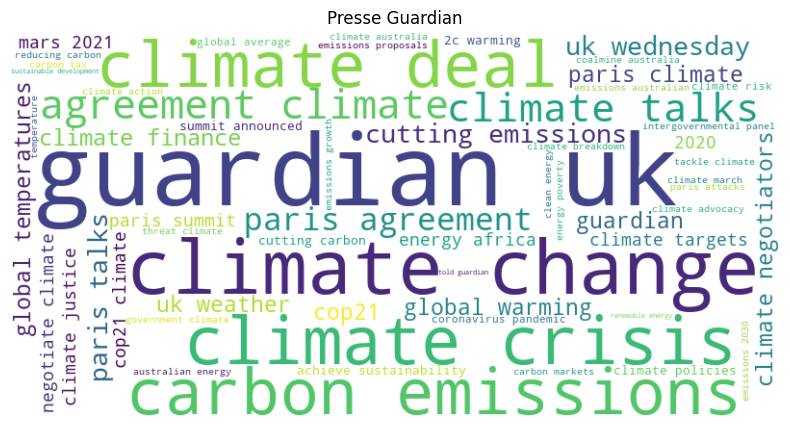

Filtered keywords from 4784 to 20


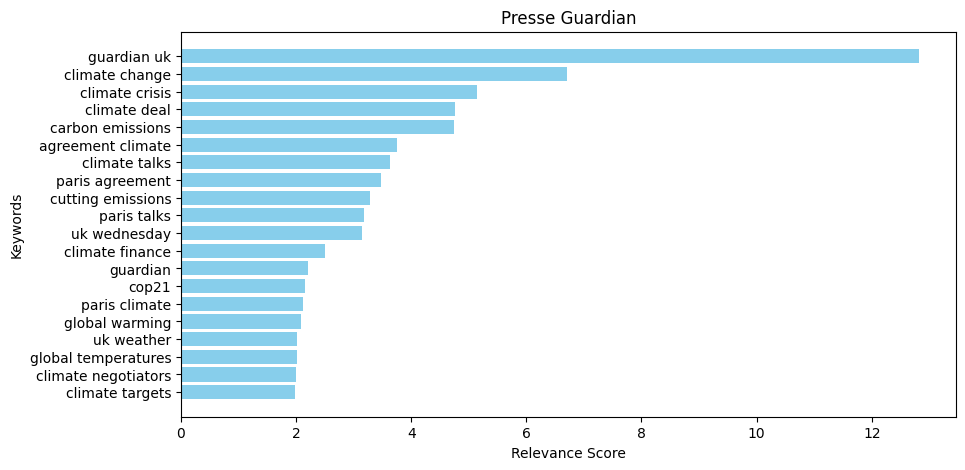

Analyzing keywords for Presse USAToday...
Extracting keywords... 166/166
Grouping similar keywords... 3153/3153
Filtered keywords from 3005 to 23


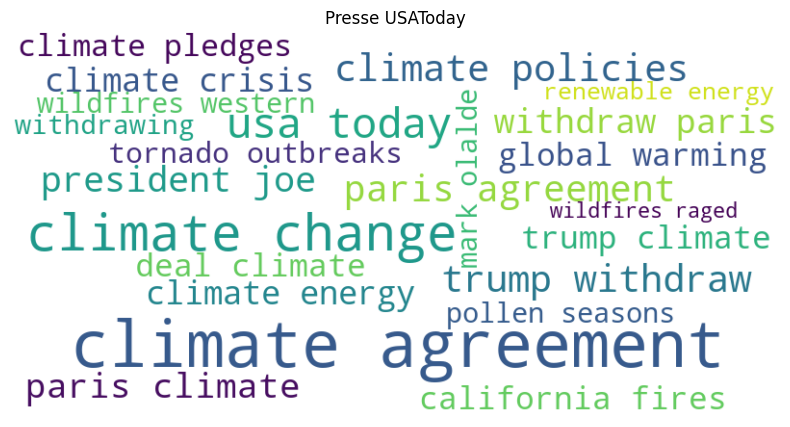

Filtered keywords from 3005 to 20


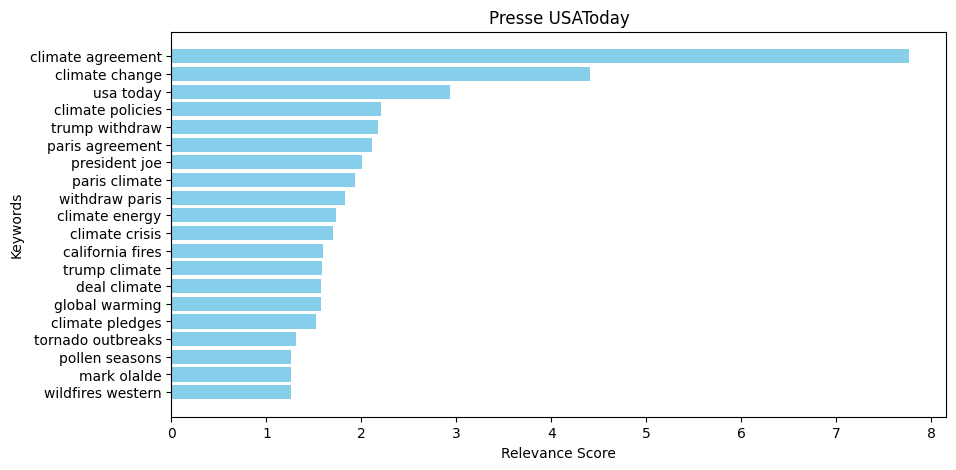

Analyzing keywords for Presse Telegraph...
Extracting keywords... 270/270
Grouping similar keywords... 5010/5010
Filtered keywords from 4721 to 59


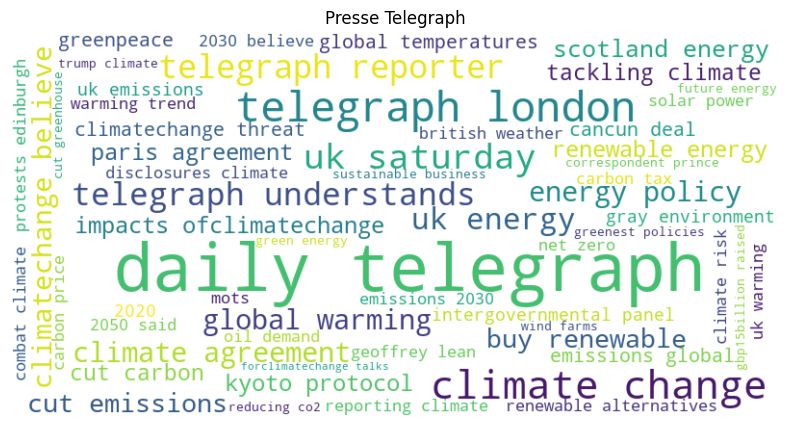

Filtered keywords from 4721 to 20


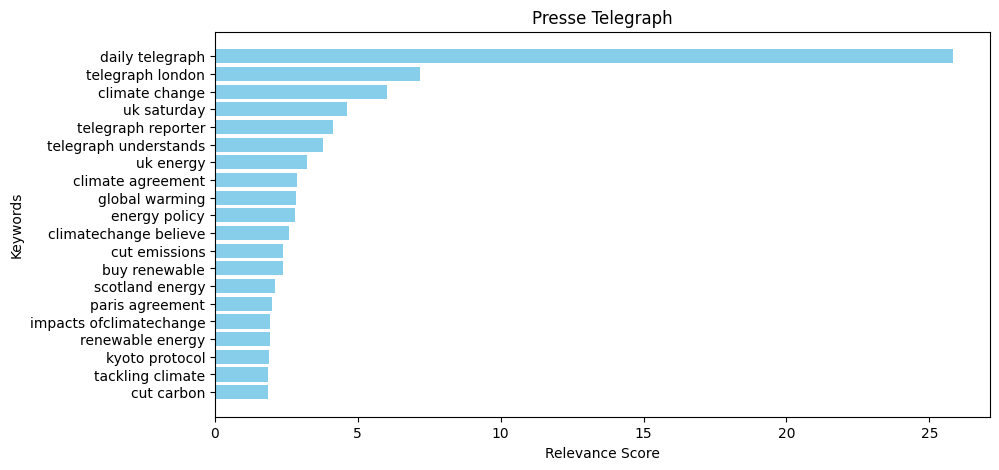

Analyzing keywords for Presse...
Extracting keywords... 1433/1433
Grouping similar keywords... 1597/25619

KeyboardInterrupt: 

In [11]:
for title in dfs:
    keyword_analysis(dfs[title], title, path_prefix="COP/plots/keyword_analysis_mmr")

In [13]:
title = "Presse"
keyword_analysis(dfs[title], title, path_prefix="COP/plots/keyword_analysis_mmr")

Analyzing keywords for Presse...
Extracting keywords... 1433/1433
Grouping similar keywords... 2688/25619

KeyboardInterrupt: 